# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости автомобиля.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признак | Описание
--- | ---
DateCrawled | дата скачивания анкеты из базы
VehicleType | тип автомобильного кузова
RegistrationYear | год регистрации автомобиля
Gearbox | тип коробки передач
Power | мощность (л. с.)
Model | модель автомобиля
Kilometer | пробег (км)
RegistrationMonth | месяц регистрации автомобиля
FuelType | тип топлива
Brand | марка автомобиля
Repaired | была машина в ремонте или нет
DateCreated | дата создания анкеты
NumberOfPictures | количество фотографий автомобиля
PostalCode | почтовый индекс владельца анкеты (пользователя)
LastSeen | дата последней активности пользователя

Целевой признак: ***Price*** - цена в евро

# Подготовка данных

В работе использовались модули следующих версий:

- seaborn==0.12.2
- matplotlib==3.6.3
- numpy==1.23.5
- pandas==1.5.3
- sklearn==1.2.1
- catboost==1.1.1
- lightgbm==3.3.5
- optuna==3.1.1
- phik==0.12.3
- torch==2.0.1

In [1]:
# подключаем все необходимые библиотеки
import os
import re
from time import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_error, make_scorer

import phik
import lightgbm as lgb

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

In [2]:
# будем замерять время работы всего ноутбука
start_notebook = time()

In [3]:
# задаем стиль по умолчанию для графиков
sns.set(style='darkgrid', rc={'figure.figsize':(10.7,7.57)}, font_scale=1.3)

In [4]:
os.environ['DATA_PATH'] = '../../YandexPracticum/datasets/'

In [5]:
files_path = os.environ['DATA_PATH']  # путь до директории с требуемым файлом

In [6]:
# загружаем данные
auto_df = pd.read_csv(f'{files_path}autos.csv')

In [7]:
# просмотрим первые пять записей
auto_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
# мы мним себя питонистами, поэтому изменим названия колонок
# решение подглядели с сайта stackoverflow
# https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case

pattern = re.compile(r'(?<!^)(?=[A-Z])')
auto_df.columns = [pattern.sub('_', col).lower() for col in auto_df.columns]

In [9]:
# выведем основную информацию по датасету
auto_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Явно есть над чем поработать. Необходимо будет обработать пропуски и привести каждую колонку к соответствующему типу данных.

In [10]:
# чтобы не допускать утечку данных, разделим данные на train и test уже на данном этапе
# на валидационную не разбиваем поскольку будем использовать кросс-валидацию
train_df, test_df = train_test_split(auto_df, shuffle=True, random_state=101, test_size=0.25)

In [11]:
# auto_df нам больше не понадобится, удалим его из памяти
del auto_df

In [12]:
# выведем число пропусков в каждой из колонок
train_df.isna().sum()

date_crawled              0
price                     0
vehicle_type          28099
registration_year         0
gearbox               14859
power                     0
model                 14711
kilometer                 0
registration_month        0
fuel_type             24623
brand                     0
repaired              53240
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [13]:
# посмотрим, сколько данных мы потеряем, если просто удалим все записи с пропусками
print('Удаление пропусков приведет к потере {:.2f}% данных'
      .format(train_df[train_df.isna().any(axis=1)].shape[0] / train_df.shape[0] * 100))

Удаление пропусков приведет к потере 30.54% данных


Многовато. Тогда будем смотреть каждую колонку в отдельности и определять, что можно сделать с пропусками.

In [14]:
# выведем уникальные значения model
train_df.model.value_counts()

golf                  21920
other                 18309
3er                   14756
polo                   9895
corsa                  9458
                      ...  
rangerover                3
serie_3                   3
serie_1                   2
i3                        2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

In [15]:
# модели часто отмечают как "other", будем заполнять пропуски этим значением
train_df.model = train_df.model.fillna("other")

In [16]:
# выведем уникальные значения vehicle_type
train_df.vehicle_type.unique()

array([nan, 'wagon', 'coupe', 'sedan', 'convertible', 'small', 'bus',
       'other', 'suv'], dtype=object)

**Предположение**: авто с одним и тем же брендом и моделью относятся к одному типу.

In [17]:
# для проверки предположения построим сводную таблицу
vehicle_type_count = train_df.pivot_table(index=['brand', 'model'], 
                                         columns='vehicle_type', 
                                         aggfunc={'vehicle_type': 'count'}, 
                                         fill_value=0)
vehicle_type_count.sample(20, random_state=42).sort_index()

vehicle_type                                           \
vehicle_type                    bus convertible coupe other sedan small  suv   
brand         model                                                            
alfa_romeo    spider              0         141     0     0     0     0    0   
audi          90                  0           1     6     0    57     0    0   
daewoo        matiz               0           0     0     0     3   100    0   
daihatsu      charade             0           0     0     0     2    12    0   
              move               10           0     0     2     1    16    0   
ford          b_max              20           0     0     0     0     0    0   
honda         cr_reihe            0          35    83     0     1     4  120   
hyundai       i_reihe            27           0     9     1   245   342  137   
kia           carnival          180           0     0     2     0     0    0   
              ceed                0           0     5     1   125     3    0   
mazda         cx_reihe            0           1     1     0     0     0   43   
mercedes_benz cl                  0           0   152     1     9     0    1   
              other             239          63   526    65  1348    39   51   
              v_klasse           97           0     0     1     0     0    0   
mitsubishi    pajero              1           0     0     1     0     0  138   
opel          antara              1           0     1     0     1     2   56   
              tigra               1         292   135     3     8    93    0   
seat          other              19           0     5    32    34    75    1   
suzuki        jimny               0           7     0     2     0     1  136   
toyota        yaris              31           0     0     3    19   679    0   

                              
vehicle_type           wagon  
brand         model           
alfa_romeo    spider       0  
audi          90           1  
daewoo        matiz        1  
daihatsu      charade      0  
              move         2  
ford          b_max        0  
honda         cr_reihe     0  
hyundai       i_reihe    115  
kia           carnival     4  
              ceed        42  
mazda         cx_reihe     0  
mercedes_benz cl           0  
              other      336  
              v_klasse     0  
mitsubishi    pajero       0  
opel          antara       7  
              tigra        0  
seat          other       18  
suzuki        jimny        0  
toyota        yaris        6

Как мы видим, данные часто заполнены либо как попало (например, кто-то посчитал тойоту ярис за минивэн), либо авто сложно отнести к какому-то одному типу. Однако можно заметить, что ячейки с правильными типами авто имеют наибольшие значения. Мы можем заполнить пропуски по следующему принципу:
- для записи с пропуском в `vehicle_type` выбираем авто с таким же брендом и такой же моделью
- заполняем тем типом, который имеет наибольшее значение для данного сочетания бренд-модель

Отметим, что для моделей со значением `other` заполнять по такому принципу не совсем корректно. В таком случае выйдет, что наша модель не будет оценивать стоимость авто в анкете, если пользователь указал модель `other` и не указал `vehicle_type`. Если заказчик потребует, чтобы и в таких анкетах авто тоже оценивались, то мы будем использовать принцип заполнения, описанный выше.

In [18]:
# для удобства переустановим индексы и в новом датафрейме
vehicle_max_count_types = vehicle_type_count.reset_index().iloc[:, :2]
vehicle_max_count_types.columns = ['brand', 'model']

# выбираем построчно те названия колонок, в которых значения наибольшие
vehicle_max_count_types['max_count_type'] = vehicle_type_count.reset_index().idxmax(axis=1, numeric_only=True)
vehicle_max_count_types['max_count_type'] = vehicle_max_count_types['max_count_type'].apply(lambda x: x[1])

# выводим результат
vehicle_max_count_types.sample(10, random_state=42)

,brand,model,max_count_type
159,mercedes_benz,v_klasse,bus
264,toyota,yaris,small
254,suzuki,jimny,suv
9,audi,90,sedan
77,ford,b_max,bus
234,seat,other,small
93,honda,cr_reihe,suv
109,kia,ceed,sedan
5,alfa_romeo,spider,convertible
172,mitsubishi,pajero,suv


In [19]:
# освободим памямять от сущностей, которые нам больше не понадобятся
del vehicle_type_count
del vehicle_max_count_types

In [20]:
# создадим класс, который заполняет пропуски в колонке vehicle_type на основе таблицы с чаще всего встречаемыми типами авто

class VehicleTypeImputer(TransformerMixin, BaseEstimator):
    
    def fit(self, X, y=None):
        vehicle_type_count = X.pivot_table(index=['brand', 'model'], 
                                           columns='vehicle_type', 
                                           aggfunc={'vehicle_type': 'count'}, 
                                           fill_value=0)
        
        vehicle_max_count_types = vehicle_type_count.reset_index().iloc[:, :2]
        vehicle_max_count_types.columns = ['brand', 'model']

        vehicle_max_count_types['max_count_type'] = vehicle_type_count.reset_index().idxmax(axis=1, numeric_only=True)
        vehicle_max_count_types['max_count_type'] = vehicle_max_count_types['max_count_type'].apply(lambda x: x[1])
        
        # сохраняем "обученную" таблицу с наиболее часто встречаемыми типами авто для пар бренд-модель
        # для моделей с отметкой `other` мы не быдем заполнять пропуски
        self.max_count_type = vehicle_max_count_types.query('model != "other"')
           
    def transform(self, X, replace_incorrect=False):
        frequent_types = X[['brand', 'model']].merge(self.max_count_type, on=['brand', 'model'], how='left')\
                                              .max_count_type
        
        frequent_types.index = X.index
        frequent_types = frequent_types.fillna('other')
        
        if replace_incorrect:
            return frequent_types.values
        
        return X.vehicle_type.fillna(frequent_types).values
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [21]:
# отлично, перейдем к заполнению пропусков
im_vehicle_type = VehicleTypeImputer()
im_vehicle_type.fit(train_df)

train_df.vehicle_type = im_vehicle_type.transform(train_df)
print('После заполнения в колонке vehicle_type осталось пропусков:', train_df.vehicle_type.isna().sum())

После заполнения в колонке vehicle_type осталось пропусков: 0


In [22]:
# проверим, что все изменения были проведены корректно
train_df.pivot_table(index=['brand', 'model'], 
                     columns='vehicle_type', 
                     aggfunc={'vehicle_type': 'count'}, 
                     fill_value=0, observed=True).sample(10, random_state=42).sort_index()

vehicle_type                                           \
vehicle_type                    bus convertible coupe other sedan small  suv   
brand         model                                                            
alfa_romeo    spider              0         150     0     0     0     0    0   
audi          90                  0           1     6     0    70     0    0   
ford          b_max              21           0     0     0     0     0    0   
honda         cr_reihe            0          35    83     0     1     4  135   
kia           ceed                0           0     5     1   139     3    0   
mercedes_benz v_klasse          108           0     0     1     0     0    0   
mitsubishi    pajero              1           0     0     1     0     0  148   
seat          other              19           0     5   106    34    75    1   
suzuki        jimny               0           7     0     2     0     1  142   
toyota        yaris              31           0     0     3    19   731    0   

                              
vehicle_type           wagon  
brand         model           
alfa_romeo    spider       0  
audi          90           1  
ford          b_max        0  
honda         cr_reihe     0  
kia           ceed        42  
mercedes_benz v_klasse     0  
mitsubishi    pajero       0  
seat          other       18  
suzuki        jimny        0  
toyota        yaris        6

In [23]:
# самое большое количество пропусков находится в колонке repaired
train_df.repaired.unique()

array(['no', nan, 'yes'], dtype=object)

In [24]:
# колонка имеет всего два значения `yes` и `no`, как-то выбрать, каким из этих значений заполнять - невозможно
# самым логичным будет заполнить пропуски заглушкой типа `unknown`
train_df.repaired = train_df.repaired.fillna('unknown')

# сделаем то же самое для `gearbox`
train_df.gearbox = train_df.gearbox.fillna('unknown')

In [25]:
# посмотрим уникальные значения в fuel_type
train_df.fuel_type.unique()

array(['petrol', 'gasoline', 'hybrid', nan, 'lpg', 'other', 'electric',
       'cng'], dtype=object)

petrol и gasoline - два названия одного и того же топлива.<br>
lpg - liquefied petroleum gas<br>
cng - compressed natural gas<br>
lpg и cng отличаются, первый состоит из пропана и бутана, второй из метана.

In [26]:
# заменим petrol на "gasoline", заполним пропуски значением "unknown", такое же значение зададим для "other"
train_df.loc[train_df.fuel_type == "petrol", 'fuel_type'] = "gasoline"
train_df.loc[train_df.fuel_type == "other", 'fuel_type'] = "unknown"
train_df.fuel_type = train_df.fuel_type.fillna('unknown')

In [27]:
# посмотрим, сколько пропусков осталось
print('В данных осталось {:.2f}% пропусков'
      .format(train_df[train_df.isna().any(axis=1)].shape[0] / train_df.shape[0] * 100))

В данных осталось 0.00% пропусков


Обратим внимание, что мы пытаемся оценить стоимость автомобиля для новой, "только что" загруженной анкеты. В этом случае нам будут недоступны временные данные, поэтому мы не будем их использовать при обучении.

In [28]:
MAX_DATE_CREATED = pd.to_datetime(train_df.date_created).dt.year.max()  # сохраним, пригодится при анализе данных
train_df = train_df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)

In [29]:
# колонки с типом `object` сделаем категориальными
for col in train_df.select_dtypes('object').columns:
    train_df[col] = train_df[col].astype('category')
    
# поскольку месяц регистрации авто едва ли связан со стоимостью продажи, удалим данный признак
train_df = train_df.drop('registration_month', axis=1)

In [30]:
# посмотрим какое максимальное значение встречается в колонке number_of_pictures
train_df.number_of_pictures.max()

0

In [31]:
# колонка для нас бесполезна, удалим её
train_df = train_df.drop('number_of_pictures', axis=1)

In [32]:
print('Число уникальных почтовых индексов:', train_df.postal_code.nunique())

Число уникальных почтовых индексов: 8089


По сути, индексы хранят в себе информацию о месте, где продавался автомобиль. В данном случае признак интересен как категориальный, а не числовой. Однако число категорий получается очень большим, что не очень хорошо для обучения. Можно было бы перевести почтовые индексы в страны или города, однако анализ, с использованием модуля `geopy` и информации с базы данных http://download.geonames.org/export/zip/, показал, что скорее всего все записи относятся только к одной стране (Германия), а если переводить индексы в города, то их также получается очень много (более 6000). В связи с этим мы не будем использовать данную колонку для нашей модели.

In [33]:
train_df = train_df.drop('postal_code', axis=1)

In [34]:
# посмотрим, есть ли полностью повторяющиеся строки
print('Число дубликатов:', train_df.duplicated().sum())
print(f'Процент дубликатов: {train_df.duplicated().sum() / train_df.shape[0] * 100:.1f}%')

Число дубликатов: 28301
Процент дубликатов: 10.6%


In [35]:
# дубликатов многовато, но они нам не помогут при обучении, поэтому удаляем
train_df = train_df.drop_duplicates()

In [36]:
print('Датафрейм занимает {:.2f} MB'
.format(train_df.memory_usage(deep=True).sum() / 1024 / 1024))
print('Размер обучающей выборки после преобразований:', train_df.shape)

Датафрейм занимает 10.67 MB
Размер обучающей выборки после преобразований: (237475, 10)


Нам удалось значительно снизить потребляемую память.

Единственное место, где мы могли допустить утечку при нашей манипуляции с данными - заполнение пропусков `vehicle_type` на основе часто встречаемых типов для пары бренд-модель. Теперь у нас есть трансформер, обученный на train данных. Осталось выполнить все заполнения пропусков и преобразования для `test_df`.

In [37]:
# создадим переменные со списками названий числовых и категориальных переменных
num_cols = ['registration_year', 'power', 'kilometer']
cat_cols = train_df.select_dtypes('category').columns.tolist()

# создадим функцию для заполнения пропусков
def process_nan(df, replace_incorrect=False):
    print('До обработки:', df.shape)

    # заполнение vehicle_type с использованием трансформера, обученного на train данных
    df.vehicle_type = im_vehicle_type.transform(df, replace_incorrect)
    
    df.model = df.model.fillna('other')
    df[['repaired', 'gearbox']] = df[['repaired', 'gearbox']].fillna('unknown')
    
    df.loc[df.fuel_type == "petrol", 'fuel_type'] = "gasoline"
    df.loc[df.fuel_type == "other", 'fuel_type'] = "unknown"
    df.fuel_type = df.fuel_type.fillna('unknown')

    df = df.drop(['date_crawled', 
                  'date_created', 
                  'last_seen', 
                  'number_of_pictures', 
                  'postal_code',
                  'registration_month'], 
                 axis=1)
    
    # df = df.dropna()

    for col in cat_cols:
        df[col] = df[col].astype('category')

    print('После обработки:', df.shape)
    display(df.head())
    df.info()
    
    return df

In [38]:
test_df = process_nan(test_df)

До обработки: (88593, 16)
После обработки: (88593, 10)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
255957,11500,wagon,2009,manual,122,octavia,70000,gasoline,skoda,no
265855,8499,sedan,2005,manual,102,passat,125000,gasoline,volkswagen,no
171328,2499,small,2003,manual,64,polo,150000,gasoline,volkswagen,no
328061,0,wagon,2007,manual,180,a6,150000,gasoline,audi,no
15126,2750,sedan,2006,manual,140,a4,150000,gasoline,audi,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 88593 entries, 255957 to 223486
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              88593 non-null  int64   
 1   vehicle_type       88593 non-null  category
 2   registration_year  88593 non-null  int64   
 3   gearbox            88593 non-null  category
 4   power              88593 non-null  int64   
 5   model              88593 non-null  category
 6   kilometer          88593 non-null  int64   
 7   fuel_type          88593 non-null  category
 8   brand              88593 non-null  category
 9   repaired           88593 non-null  category
dtypes: category(6), int64(4)
memory usage: 4.0 MB


## Промежуточный вывод

- данные загружены, разделены на обучающую и тестовую выборки;
- определены и удалены лишние признаки, которые не будут использоваться при обучении моделей;
- заполнены пропуски в данных; те пропуски, что не удалось заполнить - удалены;
- заполнение `vehicle_type` в тестовой выборке происходило только после обучения соответствующего трансформера на train выборке.

# Анализ данных

Теперь проанализируем числовые данные на наличие выбросов и ошибок. Обработка выбросов в этом пункте будут относиться только к обучающей выборке, тестовую мы никак не трогаем.

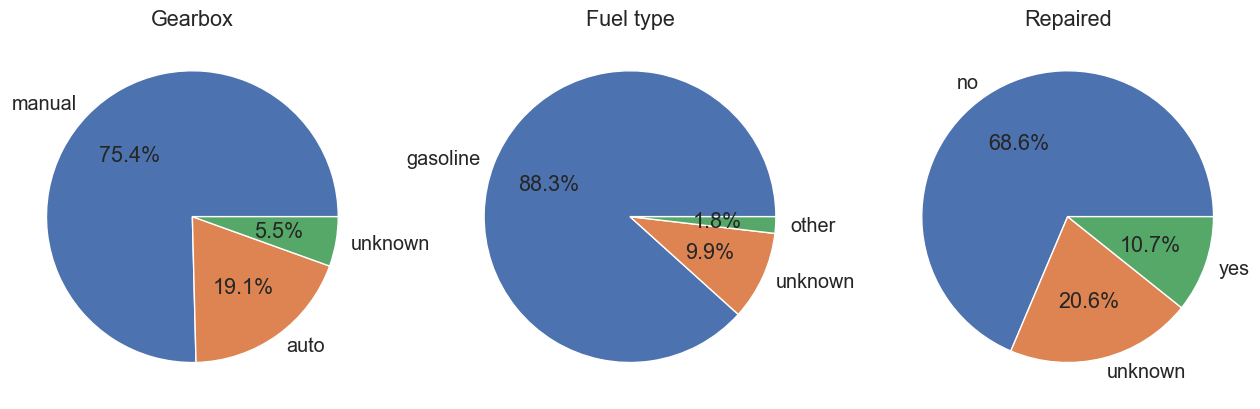

In [39]:
# построим круговые диаграммы для категориальных переменных с малым числом категорий
fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, col in enumerate(['gearbox', 'fuel_type', 'repaired']):
    values = train_df[col].value_counts()
    
    # объединим категории, которые очень немногочисленны
    if col == 'fuel_type':
        sum_other = values[values < values.unknown].sum()
        values = values[values >= values.unknown]
        values['other'] = sum_other
    
    axes[i].pie(values, labels=values.index, autopct='%.1f%%')
    axes[i].set_title(' '.join(col.capitalize().split('_')))

plt.show()

Категории явно не сбалансированы. Больше всего встречается не ремонтированные авто с ручной коробкой передач, которые используют в качестве топлива бензин.

In [40]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,7)}, font_scale=1.2)

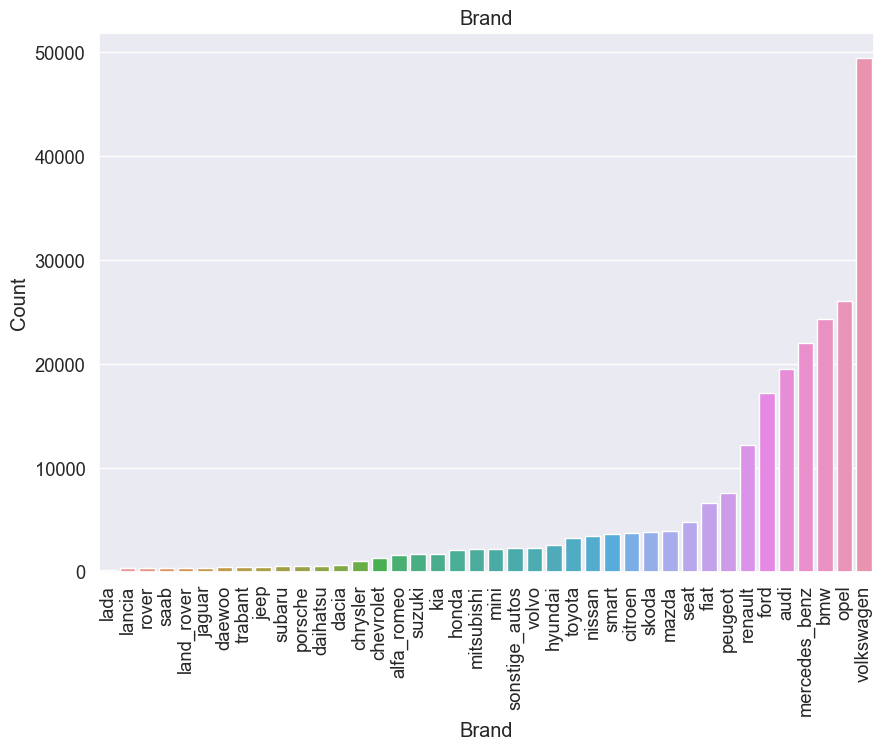

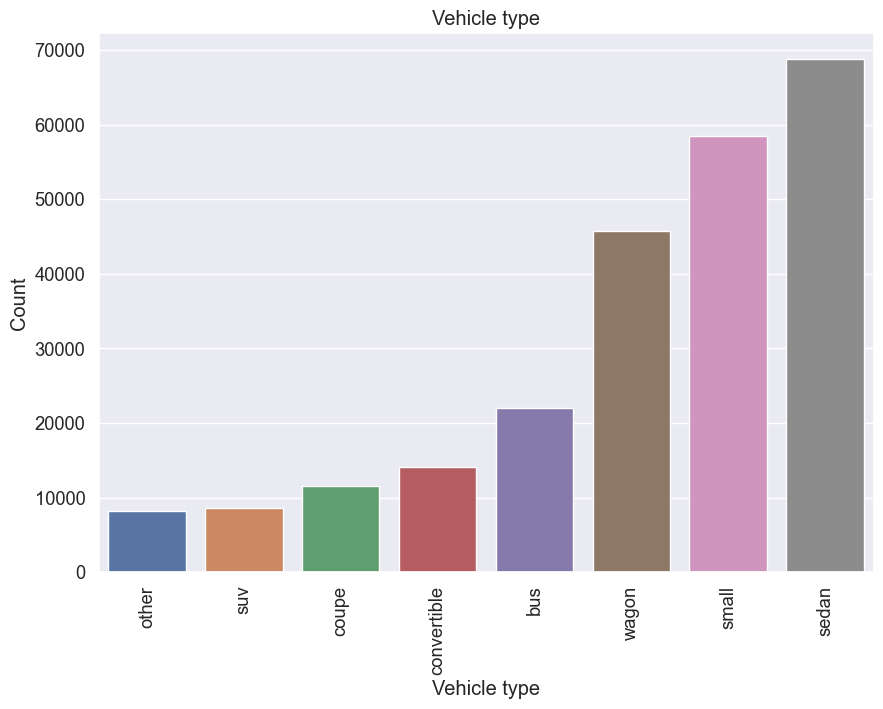

In [41]:
# для остальных построим гистограммы (кроме model, поскольку в данном признаке слишком много категорий для визуализации)
for i, col in enumerate(['brand', 'vehicle_type']):
    values = train_df[col].value_counts()

    id_sort = values.sort_values().index
    
    sns.barplot(x=values.index, y=values, order=id_sort)
    

    plt.xticks(rotation=90)
        
    plt.ylabel('Count')
    name = ' '.join(col.capitalize().split('_'))
    plt.xlabel(name)
    plt.title(name)
    
    plt.show()

По распределению брэндов видно, что первые позиции занимают немецкие марки. В принципе, это подтверждает наше предположение, что сервис работает в основном в Германии. Многие брэнды крайне скудно представлены в анкетах. Топ-3 типа авто: седан, маленькая и фургон. 

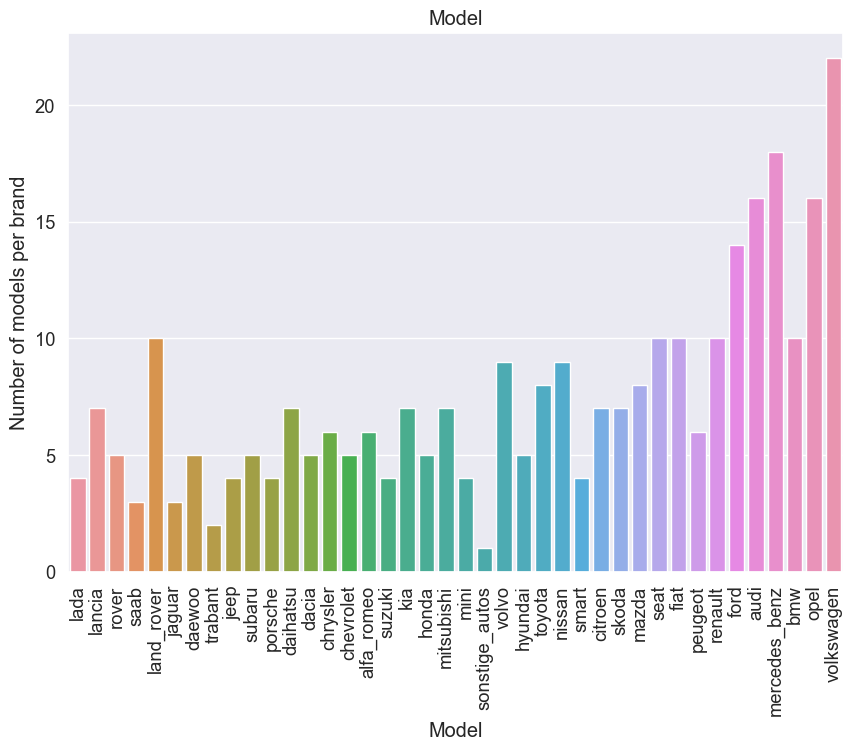

In [42]:
# построим количество моделей для кадого бренда
model_nums = train_df.groupby('brand').model.agg(lambda x: x.nunique())
id_sort = train_df.brand.value_counts().sort_values().index

# сортировать будем не по количеству моделей на бренд, а по количеству продаваемых авто на бренд
sns.barplot(x=model_nums.index, y=model_nums, order=id_sort)

plt.xticks(rotation=90)
plt.title('Model')
plt.ylabel('Number of models per brand')
plt.xlabel('Model')
plt.show()

Несмотря на слабую представленность многих брендов, в анкетах можно встретить большое разнообразие моделей. 

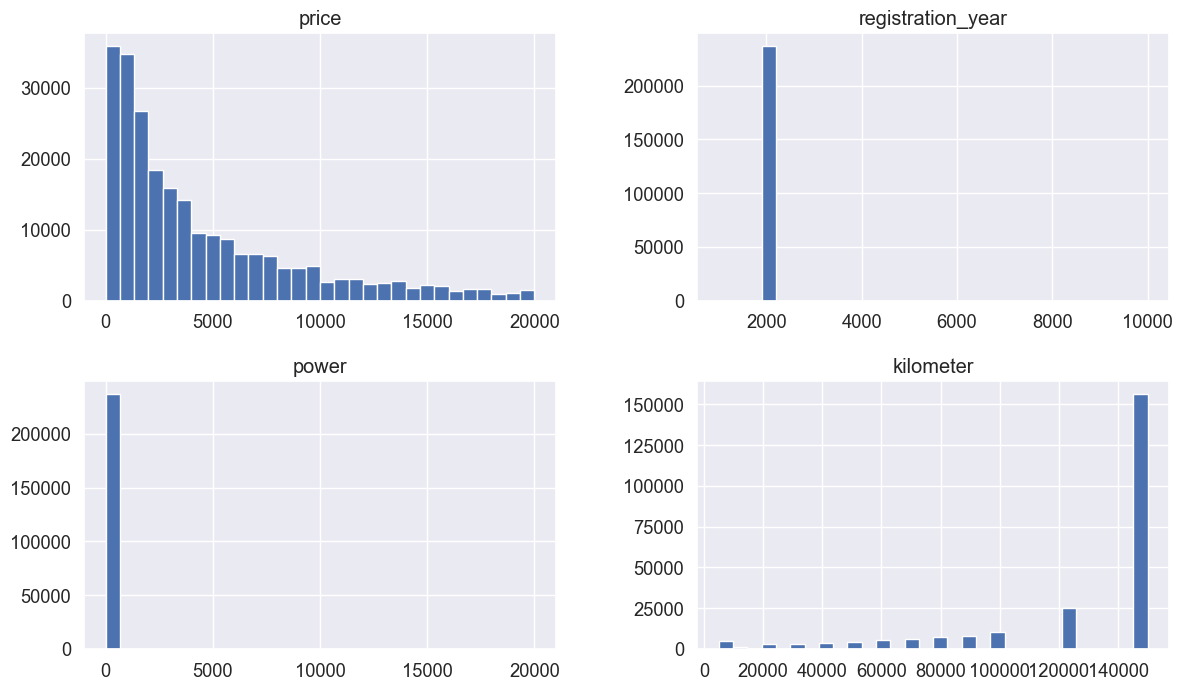

In [43]:
# построим гистограммы для числовых данных
train_df.select_dtypes(exclude='category').hist(figsize=(14, 8), bins=30);

Основные проблемы:
- цены с очень маленьким значением;
- дата регистрации авто, которая больше даты публикации анкеты, или ранее 1970 года (выбрано эмпирически);
- авто с мощностью двигателя равной 0 и очень большим значением (>600, выбрано на основе возможных максимальных значений мощности двигателя);

In [44]:
MIN_DATE_CREATED = 1970
MIN_PRICE = 500
MAX_POWER = 600

print('Число записей с неадекватными значениями registration_year: ', 
      train_df.query('registration_year < @MIN_DATE_CREATED or registration_year > @MAX_DATE_CREATED').shape[0])
print('Число записей с неадекватными значениями power', 
      train_df.query('power == 0 or power > @MAX_POWER').shape[0])
print(f'Число записей с ценами менее {MIN_PRICE}:', train_df.query('price < @MIN_PRICE').shape[0])

Число записей с неадекватными значениями registration_year:  11340
Число записей с неадекватными значениями power 27462
Число записей с ценами менее 500: 24449


Терять данные мы не хотим, поэтому попробуем как-то обработать выбросы. Используем следующий подход: группируем данные по тройке бренд-модель-дата_регистрации и для выбросов устанавливаем медианное значение (при обработке даты регистрации группируем только по паре бренд-модель).

In [45]:
# создадим функцию для замены выбросов медианными значениями
def replace(group, lower, upper):
    condition = (group.values <= lower) | (group.values >= upper)
    
    outliers = group[condition].index
    median = group[~condition].median()
    
    group[outliers] = median
    return group

# группируем данные по тройке бренд-модель-год_регистрации
group_by_three = train_df.groupby(['brand', 'model', 'registration_year'])

In [46]:
train_df.power = group_by_three.power.transform(replace, 0, MAX_POWER + 1)
train_df.price = group_by_three.price.transform(replace, MIN_PRICE, train_df.price.max() + 1)

# в случае с registration_year группируем только по паре бренд-модель
train_df.registration_year = train_df.groupby(['brand', 'model']).registration_year\
                                     .transform(replace, MIN_DATE_CREATED, MAX_DATE_CREATED + 1)

In [47]:
# поскольку мы группировали по достаточно маленьким группам, могла произойти ситуация, когда в группе находятся 
# только выбросы, как результат мы получим NaN значения
for col in ['power', 'price', 'registration_year']:
    print(f'Количество пропусков в {col}:', train_df[col].isna().sum())

    # и сразу заполним пропуски "глобальными" медианными значениями
    train_df[col] = train_df[col].fillna(train_df[col].median()).astype('int')

Количество пропусков в power: 590
Количество пропусков в price: 472
Количество пропусков в registration_year: 0


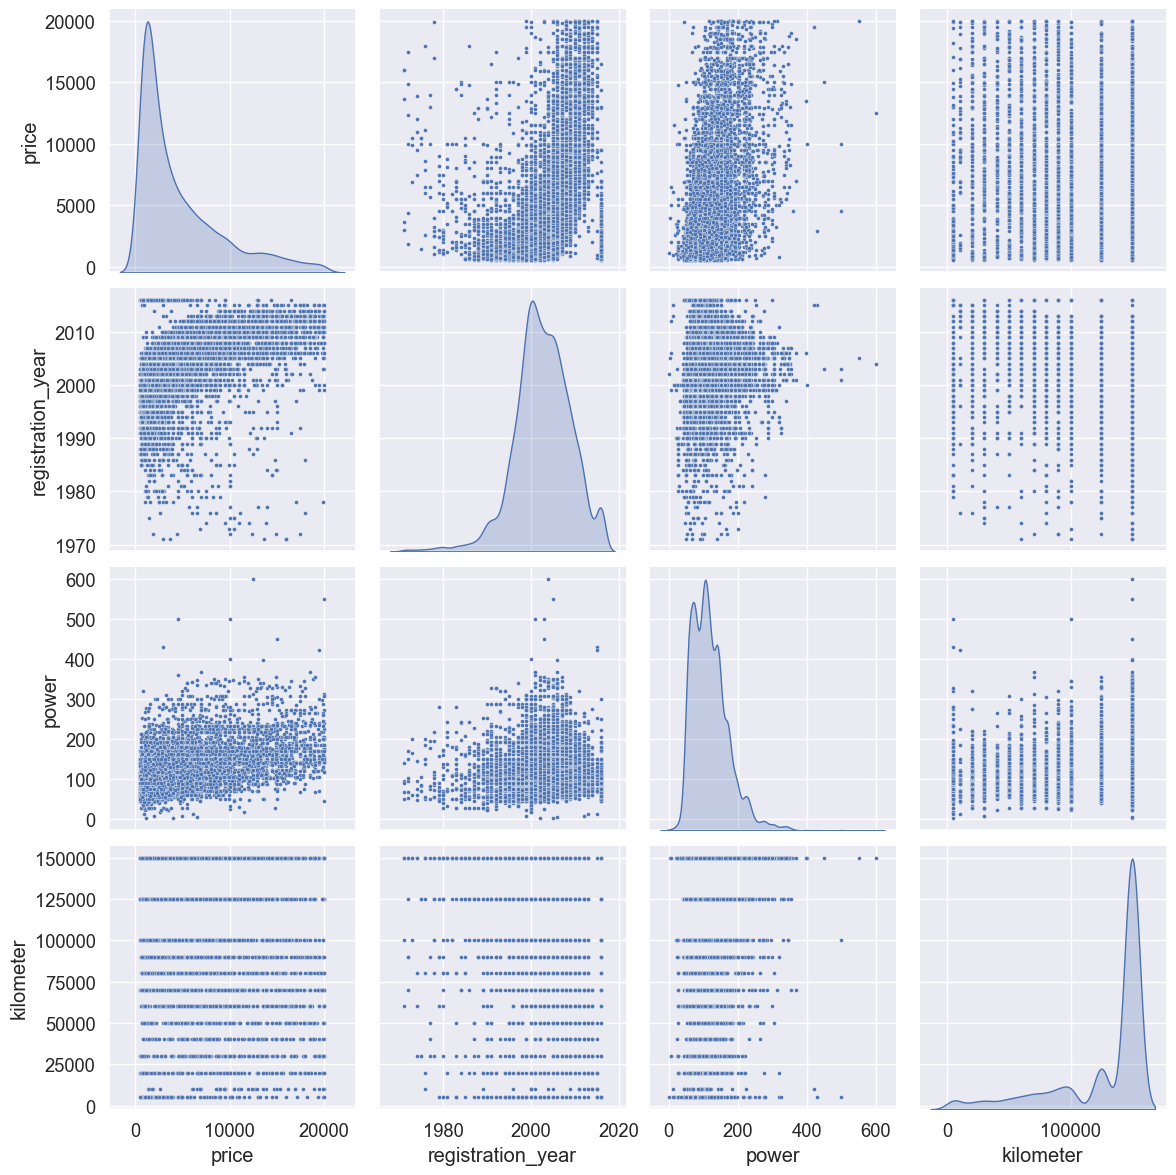

In [48]:
# построим матрицу рассеяния, возьмем только выборку из данных,иначе получится каша из точек 
sns.pairplot(train_df.sample(10000, random_state=101), plot_kws={'s': 8}, diag_kind='kde', height=3);

In [49]:
# построим матрицу коэффициентов корреляции с использованием модуля phi_K
train_df.phik_matrix(interval_cols=num_cols + ['price']).style.background_gradient()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.264505,0.647725,0.284085,0.500644,0.569198,0.309469,0.123943,0.354951,0.345727
vehicle_type,0.264505,1.000000,0.203807,0.305202,0.463807,0.920014,0.175599,0.197820,0.639174,0.198856
registration_year,0.647725,0.203807,1.000000,0.152993,0.271980,0.649119,0.396997,0.131553,0.367781,0.248780
gearbox,0.284085,0.305202,0.152993,1.000000,0.448726,0.615329,0.081944,0.455446,0.513743,0.466183
power,0.500644,0.463807,0.271980,0.448726,1.000000,0.769191,0.092222,0.105557,0.560748,0.147005
model,0.569198,0.920014,0.649119,0.615329,0.769191,1.000000,0.430977,0.339030,0.997729,0.275045
kilometer,0.309469,0.175599,0.396997,0.081944,0.092222,0.430977,1.000000,0.104834,0.274056,0.241970
fuel_type,0.123943,0.197820,0.131553,0.455446,0.105557,0.339030,0.104834,1.000000,0.206067,0.381170
brand,0.354951,0.639174,0.367781,0.513743,0.560748,0.997729,0.274056,0.206067,1.000000,0.159182
repaired,0.345727,0.198856,0.248780,0.466183,0.147005,0.275045,0.241970,0.381170,0.159182,1.000000


In [50]:
# снова посмотрим, есть ли дубликаты
print('Число дубликатов:', train_df.duplicated().sum())

Число дубликатов: 9119


In [51]:
# here we go again
train_df = train_df.drop_duplicates()

# будем использовать чуть меньше памяти для записи двух признаков
train_df.registration_year = pd.to_numeric(train_df.registration_year, downcast='integer')
train_df.power = pd.to_numeric(train_df.power, downcast='integer')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228356 entries, 93818 to 176991
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              228356 non-null  int32   
 1   vehicle_type       228356 non-null  category
 2   registration_year  228356 non-null  int16   
 3   gearbox            228356 non-null  category
 4   power              228356 non-null  int16   
 5   model              228356 non-null  category
 6   kilometer          228356 non-null  int64   
 7   fuel_type          228356 non-null  category
 8   brand              228356 non-null  category
 9   repaired           228356 non-null  category
dtypes: category(6), int16(2), int32(1), int64(1)
memory usage: 6.8 MB


C:\Users\Sergei\AppData\Local\Temp\ipykernel_12480\1448768472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.registration_year = pd.to_numeric(train_df.registration_year, downcast='integer')
C:\Users\Sergei\AppData\Local\Temp\ipykernel_12480\1448768472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.power = pd.to_numeric(train_df.power, downcast='integer')


## Промежуточный вывод

- были выявлены основные закономерности в категориальных признаках;
- были обнаружены и обработаны выбросы в числовых признаках;
- построены корреляционная матрица и матрица рассеяния, из которых было выявлено следующее:
    - целевая переменная больше всего коррелирует с годом регистрации автомобиля, его моделью и мощностью двигателя, зависимость от года регистрации нелинейная;
    - название бренда сильно коррелирует с названием модели (что, на самом деле, не удивительно, обычно названия моделей у разных брендов не пересекаются), типом автомобиля, мощностью двигателя и типом коробки передач. Та же закономерность наблюдается  и для названия модели;
    - значения в колонке `kilometer` принимают только 13 значений

Поскольку категорий в признаках `brand` и `model` много, модели скорее всего будут обучаться достаточно долго. Создадим функцию, которая будет уменьшать количество категорий в данных признаках по следующему принципу:
- берем 20 самых редких бренда, разбиваем их на два списка - в одном будут "дешевые" бренды, во втором "дорогие"
- название бренда и модели заменяем на `cheap` и `expensive`, соответственно

Мы сравним как поменяется скорость обучения и качество модели только для тех моделей, которые покажут наилучшие результаты после обучения на подготовленных данных без сокращения категорий.

In [52]:
class CatReducer:
    def __init__(self):
        self.rare_brands = None
        self.rare_models = None
        self.cheap_brands = None
        self.expensive_brands = None
        
    def fit(self, df):
        # определяем редкие бренды
        self.rare_brands = df.brand.value_counts()\
                             .sort_values().index.values[:20].to_list()

        # сортируем по медианной цене
        ordered = df.query('brand in @self.rare_brands').groupby('brand').price.median()\
                    .dropna().sort_values().index.to_list()

        # делим на дешевые и дорогие
        self.cheap_brands = ordered[:10]
        self.expensive_brands = ordered[10:]

        # получаем список моделей для указанных брендов
        self.rare_models = df.query('brand in @self.cheap_brands or brand in @self.expensive_brands')\
                             .model.unique().to_list()


    def transform(self, df):
        df_copy = df.copy(deep=True)
        
        for col, rare in zip(['model', 'brand'], [self.rare_models, self.rare_brands]):
            # добавляем категории в признак
            df_copy[col] = df_copy[col].cat.add_categories(['cheap', 'expensive'])
            
            # переопределяем названия на cheap и expensive
            df_copy.loc[df_copy.brand.isin(self.cheap_brands), col] = 'cheap'
            df_copy.loc[df_copy.brand.isin(self.expensive_brands), col] = 'expensive'
            
            # удаляем лишние категории из признака
            df_copy[col] = df_copy[col].cat.remove_unused_categories()
            
    
        return df_copy

# Подготовка и обучение моделей

После всех наших манипуляций с данными мы наконец-то готовы перейти к построению различных моделей и их обучению.

In [53]:
# разделим обучающую и тестовую выборки на признаки и таргет
X_train = train_df.drop('price', axis=1)
y_train = train_df.price

X_test = test_df.drop('price', axis=1)
y_test = test_df.price

In [54]:
def rmse(y_true, y_predicted) -> float:
    """
    Расчет метрики Root mean squared error
    
    Parameter:
    ---------
    y_true: ndarray or Series
        истинные значения целевой переменной
    y_predicted: ndarray or Series
        предсказанные значения целевой переменной
    
    Returns:
    -------
    RMSE: float
    """
    return np.sqrt(mean_squared_error(y_true, y_predicted))

Для оценки времени работы ячейки обычно используется магическая команда `%%time`. Однако для удобного сравнения времен в сводной таблице это не совсем подойдет.

In [55]:
# для удобного сравнения времени обучения разных моделей создадим соответствующий класс
class Timer:
    def __init__(self):
        self.elapsed_time = None
    
    # таймер будет работать в виде контекстного менеджера
    def __enter__(self):
        self.__start = time()
        
    def __exit__(self, exc_type, exc_value, exc_tb):
        self.elapsed_time = time() - self.__start
        
train_timer = Timer()
predict_timer = Timer()

In [56]:
def get_model_name(model) -> str:
    """
    Получить название обучаемой модели-оценщика
    
    Parameters:
    ----------
    model: Pipeline or OptunaSearchCV or GridSearchCV
        пайплайн или гридсерч с моделью-оценщиком
    
    Returns:
    -------
    estimator class name: str
        название модели-оценщика
    """
    
    if isinstance(model, Pipeline):
        title = model[-1].estimator.__class__.__name__
    elif isinstance(model, lgb.LGBMRegressor):
        title = model.__class__.__name__
    else:
        title = model.estimator.__class__.__name__
    return title

In [57]:
# для визульного сравнения отклонений предсказанных значений от истинных будем строить график
def plot_train_results(y_true, y_predicted, title) -> None:
    """
    Построение зависимостей predict(true) и true(true)
    
    Parameters:
    ----------
    y_true: array-like
        истинные значения price
    y_predicted: array-like
        предсказанные моделью значения price
    title: str
        название модели
    """
    plt.plot(y_true, y_predicted, 'o', label=f'Predicted', alpha=0.6, markersize=4,)
    plt.plot(y_true, y_true, 'ro', label=f'True', alpha=0.6, markersize=4)

    plt.legend(loc=4, facecolor='white')
    plt.title(title)
    plt.xlabel('True price')
    plt.ylabel('Predicted price')

In [58]:
def plot_models_results(*models, X, y) -> None:
    """
    Построение зависимостей predict(true) и true(true) для нескольких моделей
    
    Parameters:
    ----------
    *model: Pipeline or GridSearchCV or OptunaSearchCV
        обучаемые модели
    X: ndarray or DataFrame
        признаки
    y: ndarray or Series
        целевая переменная
    """
    # чтобы избежать каши из точек на графиках возьмем только небольшую выборку
    idx = y.sample(9000, random_state=101).index
    
    plt.figure(figsize=(16, 5))
    
    for i, model in enumerate(models):
        # получаем названия моделей
        title = get_model_name(model)
        
        # строим
        plt.subplot(1, len(models), i + 1)
        plot_train_results(y.loc[idx], model.predict(X.loc[idx]), title)

In [59]:
# создадим функцию для обучения моделей и вывода основной информации
def train_model(model, X, y):
    """
    Обучение моделей и вывод основных результатов. Сохранение качества модели, времени обучения и
    времени предсказания в датафрейм results.
    
    Parameters:
    ----------
    model: Pipeline or GridSearchCV or OptunaSearchCV
        обучаемая модель
    X: ndarray or DataFrame
        признаки
    y: ndarray or Series
        целевая переменная
    """
    title = get_model_name(model)
    
    # обучаем и замеряем время
    with train_timer:
        model.fit(X, y)
        
    with predict_timer:
        model.predict(X)
        
    if isinstance(model, Pipeline):
        cv = model[-1]
    else:
        cv = model
    
    # выводим время обучения и RMSE
    print(f'\nElapsed time: {train_timer.elapsed_time:.2f}s')
    print(f'        RMSE: {-cv.best_score_:.0f}')
    
    # если есть информация, выводим лучшие параметры модели
    if cv.best_params_:
        print('\nBest parameters:')
        for key, val in cv.best_params_.items():
            print(f'{key}: {val}')
    
    # сохраняем результаты в датафрейм
    results.loc[title] = [-cv.best_score_, train_timer.elapsed_time, predict_timer.elapsed_time]
    
    return model

In [60]:
# основную информацию (RMSE, время обучения) для всех рассматриваемых моделей будем сохранять в датафрейм
results = pd.DataFrame(columns=['RMSE', 'train_time', 'predict_time'])

## Линейные модели

Линейные модели не умеют обучаться на категориальных признаках, мы их будем кодировать с помощью one-hot векторов. Для численных признаков будем выполнять стандартное z-преобразование.

In [61]:
# преобразования для категориальных и числовых признаков 
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),  # не забываем про dummy ловушку
    ('scaler', StandardScaler(), num_cols),
], remainder='passthrough')

# параметры для GridSearchCV
gs_params = {
    'scoring': make_scorer(rmse, greater_is_better=False),
    'n_jobs': -1,
    'verbose': 1,
    'refit': True,
    'cv': 3  # поскольку нам надо обучать модели быстро, ограничимся 3 фолдами
}

# функция для создания линейных моделей
def lin_model_creator(estimator, grid_params):
    return Pipeline([
        ('transformer', ct),
        ('model', GridSearchCV(
            estimator, grid_params, **gs_params
        ))
    ])

In [62]:
# начнем с простой линейной регрессии
linreg_model = lin_model_creator(
    LinearRegression(), {}
)

train_model(linreg_model, X_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Elapsed time: 6.14s
        RMSE: 2714


In [63]:
# продолжим с ridge моделью
ridge_model = lin_model_creator(
    Ridge(random_state=101), 
    {'alpha': np.concatenate((np.linspace(0.1, 1, 10), np.linspace(2, 10, 9)))}
)

train_model(ridge_model, X_train, y_train);

Fitting 3 folds for each of 19 candidates, totalling 57 fits

Elapsed time: 14.38s
        RMSE: 2713

Best parameters:
alpha: 2.0


In [64]:
# а закончим на SGD регрессоре
sgd_model = lin_model_creator(
    SGDRegressor(random_state=101, tol=0.0001), 
    {'alpha': np.concatenate((np.linspace(0.0002, 0.001, 4),
                              np.linspace(0.002, 0.01, 4)))}
)

train_model(sgd_model, X_train, y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Elapsed time: 17.73s
        RMSE: 2731

Best parameters:
alpha: 0.0002


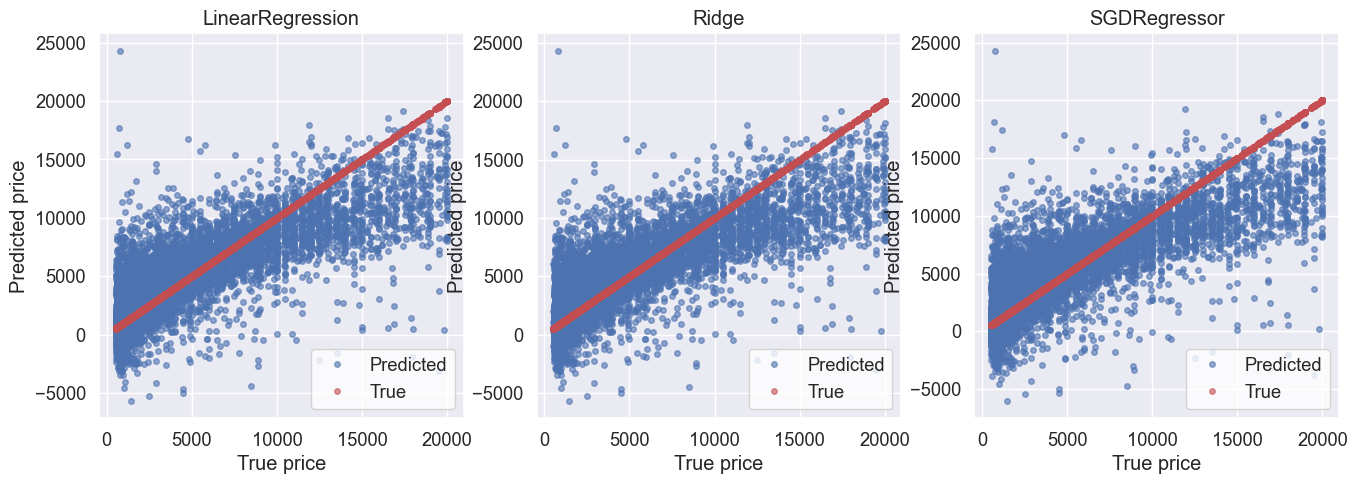

In [65]:
# построим графики для всех моделей
plot_models_results(linreg_model, ridge_model, sgd_model, X=X_train, y=y_train)

In [66]:
# выведем сводную таблицу с основными метриками
results.style.format(precision=1)

,RMSE,train_time,predict_time
LinearRegression,2713.7,6.1,0.4
Ridge,2713.4,14.4,0.4
SGDRegressor,2730.9,17.7,0.3


Никакая из обученных линейных моделей нас не удовлетваоряет (RMSE > 2500).

## Простая нейронная сеть

Нейронная сеть вряд ли окажется быстрой, однако все же попробуем обучить сеть с достаточно простой архитектурой. В качестве функций активации будем использовать LeakyReLU, после которых будем проводить нормализацию. Для уменьшения вероятности переобучения добавим Dropout. 

In [67]:
class NN(nn.Module):
    def __init__(self, in_features):
        super().__init__()
    
        self.net = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.LeakyReLU(),
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.2),
            
            nn.Linear(in_features, in_features),
            nn.LeakyReLU(),
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.2),
            
            nn.Linear(in_features, in_features // 2),
            nn.LeakyReLU(),
            nn.Linear(in_features // 2, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [68]:
def plot_losses(losses):
    """
    Построение изменений значений RMSE при обучении нейросети
    
    Parameters:
    ----------
    losses: dict[list]
        значения sMAPE на разных этапах обучения
    """
    
    fig = plt.Figure()
    
    for loss_name, data in losses.items():
        plt.plot(range(1, len(data) + 1), data, '-', label=loss_name)

    plt.legend(facecolor='white')

    plt.title('Losses per epoch')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')

    plt.show()

In [69]:
def train_net(net, optimizer, criterion, train_data, n_epochs=15):
    """
    Обучение нейронной сети.
    
    Parameters:
    ----------
    net: (nn.Model)
        нейронная сеть
    optimizer: torch.optim
        оптимизатор
    criterion: func
        функция потерь
    train_data: tuple[pd.DataFrame или pd.Series]
        обучающие данные
    n_epochs: int (default=12)
        число итераций обучения
    """
    
    y, X = train_data
        
    # переводим данные в тип tensor    
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=101, train_size=0.75)
    
    losses = {'train': [], 'valid': []}
    
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.9)
    loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=256)
    
    with train_timer:
        for epoch in range(n_epochs):
            loss_per_epoch = []

            net.train()
            for X_batch, y_batch in loader:
                y_pred = net(X_batch)
                loss = criterion(y_batch, y_pred)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # scheduler.step()

                loss_per_epoch.append(loss.cpu().detach().numpy())

            losses['train'].append(np.mean(loss_per_epoch))

            with torch.no_grad():
                net.eval()
                y_pred = net(X_valid)
                loss = criterion(y_valid, y_pred)
                losses['valid'].append(loss.cpu().detach().numpy())

            clear_output(wait=True)
            plot_losses(losses)
            
    with predict_timer:
        predict = net(X).cpu().detach().numpy()
    
    k = 6 if n_epochs >= 10 else 1 
    results.loc['SimpleNet'] = [float(np.mean(losses['valid'][-k:])), train_timer.elapsed_time, predict_timer.elapsed_time]
    return predict

In [70]:
# для нейронной сети расчет RMSE будем проводить с использованием nn.MSELoss()
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

In [71]:
torch.cuda.manual_seed_all(42)

In [72]:
# преобразовывать данные для нейронной сети будем немного по-другому
linear_transform = ColumnTransformer([
    ('cat_features', OneHotEncoder(drop='first'), cat_cols),
    ('num_features', Pipeline([('features', FeatureUnion([('poly', PolynomialFeatures()),
                                                          ('log', FunctionTransformer(np.log))])),
                               ('scaler', StandardScaler())]), num_cols)
], remainder='passthrough')

linear_transform.fit(X_train)

X_ohe_train = linear_transform.transform(X_train).toarray()

In [73]:
# если есть возможность, будем обучаться на GPU
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# создадим модель для предсказания recovery чернового концентрата
simple_net = NN(X_ohe_train.shape[1]).to(DEVICE)
criterion = RMSELoss()

optimizer = torch.optim.Adam(
    simple_net.parameters(), 
    lr=0.01,                   # задаем скорость обучения
    weight_decay=1e-4         # добавляем регуляризацию
)

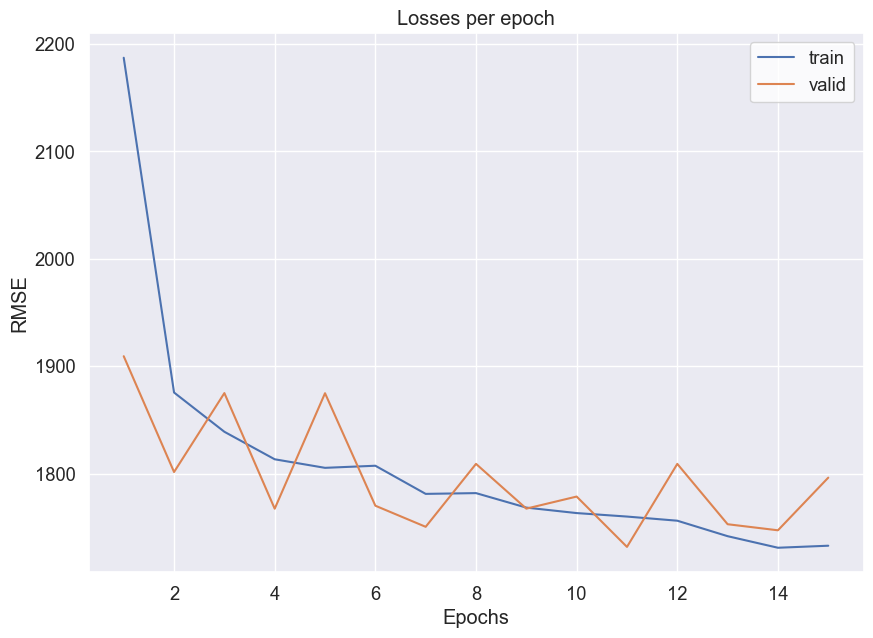

In [74]:
# обучаем
y_pred = train_net(simple_net, optimizer, criterion, 
                   (y_train.values, X_ohe_train), 15)

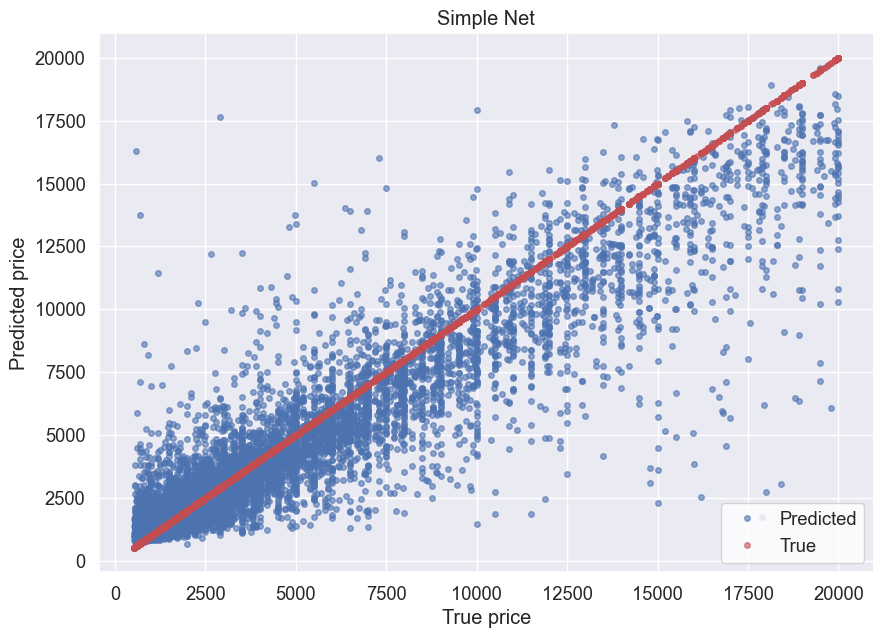

In [75]:
idx = y_train.sample(9000, random_state=101).index
y_pred = pd.Series(y_pred.reshape(-1), index=y_train.index)

# построим график результатов
with torch.no_grad():
    plot_train_results(y_train[idx], y_pred[idx], title='Simple Net')

In [76]:
results.style.format(precision=1)

,RMSE,train_time,predict_time
LinearRegression,2713.7,6.1,0.4
Ridge,2713.4,14.4,0.4
SGDRegressor,2730.9,17.7,0.3
SimpleNet,1769.5,83.8,1.0


Результат RMSE получается лучше, чем для простых линейных моделей (хотя бы не предсказываются отрицательные цены), однако время обучения и предсказания заметно выше.

In [77]:
# поскольку X_ohe_train занимает много памяти, пока что его удалим (при необходимости создадим заново)
del X_ohe_train

## Градиентный бустинг

Скорее всего в данном пункте находится победитель:) Мы посмотрим только один бустинг LightGBM, поскольку бустинги достаточно долго обучаются.

In [78]:
lgb_model = OptunaSearchCV(lgb.LGBMRegressor(random_state=101, max_depth=6),
                           {'n_estimators': IntDistribution(100, 500, step=200)},
                           **gs_params)
lgb_model = train_model(lgb_model, X_train, y_train);

C:\Users\Sergei\AppData\Local\Temp\ipykernel_12480\3645192340.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgb_model = OptunaSearchCV(lgb.LGBMRegressor(random_state=101, max_depth=6),
[I 2023-06-18 19:22:59,695] A new study created in memory with name: no-name-4f6072c9-d267-4a47-9406-e27e585e4557
[I 2023-06-18 19:22:59,696] Searching the best hyperparameters using 228356 samples...
[I 2023-06-18 19:23:09,951] Trial 9 finished with value: -1745.0389274436018 and parameters: {'n_estimators': 100}. Best is trial 9 with value: -1745.0389274436018.
[I 2023-06-18 19:23:10,137] Trial 2 finished with value: -1745.0389274436018 and parameters: {'n_estimators': 100}. Best is trial 9 with value: -1745.0389274436018.
[I 2023-06-18 19:23:10,407] Trial 5 finished with value: -1745.0389274436018 and parameters: {'n_estimators': 100}. Best is trial 9 with value: -1745.0389274436018.
[I 2023-06-18 19:23:10,946] Trial 7 fin


Elapsed time: 28.31s
        RMSE: 1694

Best parameters:
n_estimators: 500


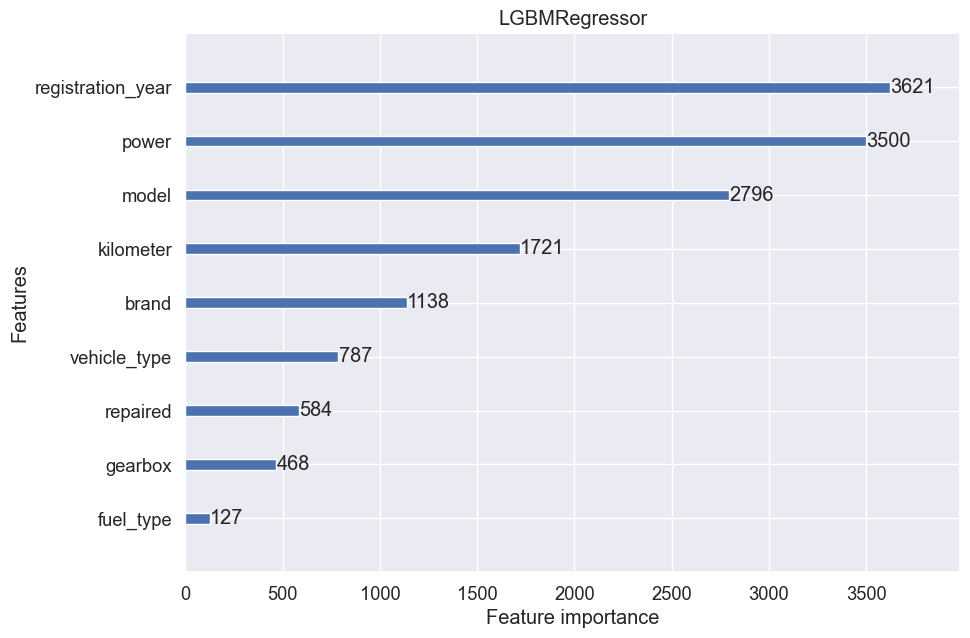

In [79]:
# выведем наиболее важные признаки для модели
lgb.plot_importance(lgb_model.best_estimator_, title='LGBMRegressor');

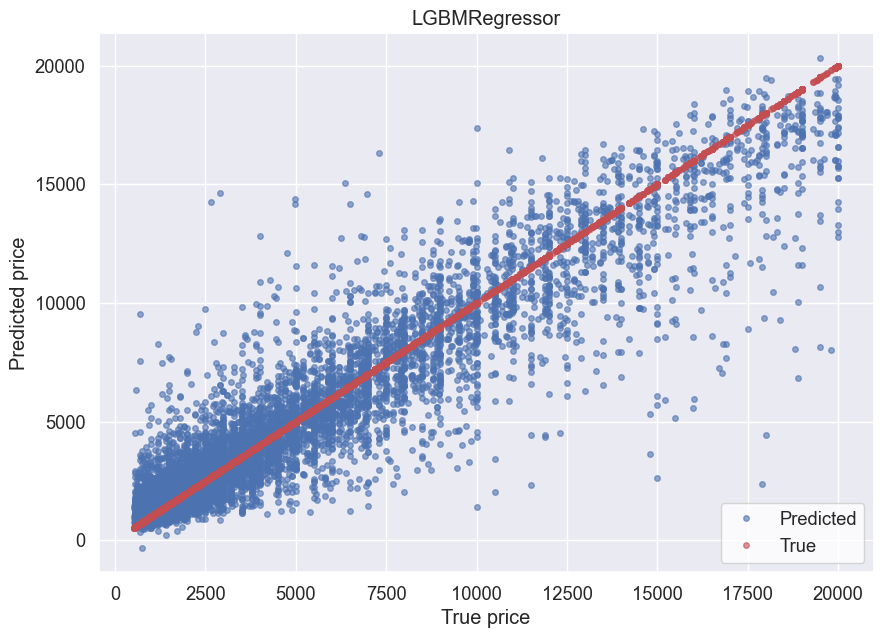

In [80]:
# построим график результатов предсказаний
idx = y_train.sample(9000, random_state=101).index
plot_train_results(y_train[idx], lgb_model.predict(X_train.loc[idx]), title='LGBMRegressor')

In [81]:
results.style.format(precision=1)

,RMSE,train_time,predict_time
LinearRegression,2713.7,6.1,0.4
Ridge,2713.4,14.4,0.4
SGDRegressor,2730.9,17.7,0.3
SimpleNet,1769.5,83.8,1.0
LGBMRegressor,1694.0,28.3,1.3


Как мы видим, градиентный бустинг имеет один из лучших результатов RMSE, при этом обучается быстрее нейросети. Наболеее важными для модели являются признаки:
- power
- registration_year
- model
- kilometer
- brand

## Промежуточный вывод

- Линейные модели показали свою несостоятельность. Скорее всего нужно более детально и скурпулезно подойти к подготовке данных чтобы модели удовлетворяли всем требованиям;
- Как и ожидалось, градиентный бустинг показывает наилучший результат RMSE, однако обучается и предсказывает дольше;
- Нейронная сеть показывает себя лучше простых линейных моделей и сопоставима с градиентным бустингом, однако обучается ещё дольше.

# Тестирование лучшей модели

Учитывая, что LightGBM удовлетворяет требованиям RMSE < 2500 и обучается быстрее нейросети (хоть и немного проигрывает в скорости предсказания) выбираем данную модель.

In [82]:
# освободим память от моделей, которые не будем использовать
del linreg_model 
del ridge_model 
del sgd_model
del simple_net

In [83]:
res = results.copy(deep=True)
results = pd.DataFrame(columns=res.columns)

In [84]:
# попробуем теперь обучиться на выборке с меньшим числом категорий в признаках бренд и модель
reducer = CatReducer()
reducer.fit(train_df)

X_train_reduced = reducer.transform(train_df).drop('price', axis=1)

# а также уберем ошибки в колонке vehicle_type
X_train_reduced.vehicle_type = im_vehicle_type.transform(X_train_reduced, True)
X_train_reduced.vehicle_type = X_train_reduced.vehicle_type.astype('category')

In [85]:
X_train_reduced.sample(5, random_state=101)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
107771,other,2006,auto,205,other,30000,gasoline,citroen,no
189084,sedan,2001,manual,203,a3,150000,gasoline,audi,no
114816,other,1998,manual,147,cheap,150000,gasoline,cheap,no
31204,small,2004,manual,75,ibiza,125000,gasoline,seat,no
316504,other,1999,manual,110,other,150000,gasoline,opel,unknown


In [86]:
# grid search больше не будем проводить, оптюну используем только для кросс-валидации
lgb_model_reduced = OptunaSearchCV(lgb.LGBMRegressor(random_state=101, n_estimators=250),
                                   {}, **gs_params)
lgb_model_reduced = train_model(lgb_model_reduced, X_train_reduced, y_train);

C:\Users\Sergei\AppData\Local\Temp\ipykernel_12480\4077731543.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  lgb_model_reduced = OptunaSearchCV(lgb.LGBMRegressor(random_state=101, n_estimators=250),
[I 2023-06-18 19:23:30,223] A new study created in memory with name: no-name-fcb8ff11-21b3-43a2-9410-bdaeb042c6b3
[I 2023-06-18 19:23:30,224] Searching the best hyperparameters using 228356 samples...
[I 2023-06-18 19:23:50,610] Trial 3 finished with value: -1783.5642780680992 and parameters: {}. Best is trial 3 with value: -1783.5642780680992.
[I 2023-06-18 19:23:50,814] Trial 5 finished with value: -1783.5642780680992 and parameters: {}. Best is trial 3 with value: -1783.5642780680992.
[I 2023-06-18 19:23:50,832] Trial 4 finished with value: -1783.5642780680992 and parameters: {}. Best is trial 3 with value: -1783.5642780680992.
[I 2023-06-18 19:23:51,228] Trial 0 finished with value: -1783.5642780680992 and pa


Elapsed time: 23.53s
        RMSE: 1784


In [87]:
# выведем сравнение моделей
results.index = ['LGBMRegressor_reduced']

pd.concat([res.loc[['LGBMRegressor'], :], results])

,RMSE,train_time,predict_time
LGBMRegressor,1694.018410,28.313330,1.253742
LGBMRegressor_reduced,1783.564278,23.526876,0.535115


Никакого положительного эффекта не наблюдается. Ох как бы научиться этому вашему feature engineering:((

In [88]:
# протестируем лучшую модель
with predict_timer:
    print(f'Test RMSE: {rmse(y_test, lgb_model.predict(X_test)):.0f}')
print(f'Predict time: {predict_timer.elapsed_time:.1f}')

Test RMSE: 1846
Predict time: 0.5


Лучшая модель отвечает всем требованиям (я надеюсь, вообще нужно уточнять у заказчика):
- RMSE < 2500
- время обучения и предсказания небольшие

In [89]:
notebook_worktime = time() - start_notebook

minutes = notebook_worktime // 60
seconds = notebook_worktime % 60

print(f'Время выполнения ноутбука: {int(minutes)} min {int(seconds)} s')

Время выполнения ноутбука: 3 min 24 s


# Вывод

- проведена предобработка данных, причем таким образом, чтобы не допустить утечки при тестировании лучшей модели;
- построены и обучены различные модели: простые линейные, градиентный бустинг и нейронная сеть;
- самой быстрообучаемой моделью с хорошим RMSE оказалась LightGBMRegressor, что было подтверждено на тестовых данных;
- условия заказчика выполнены, надеюсь он останется довольным